In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Section 9.5.2

In [2]:
df = pd.read_csv("data/data-conc-2-NA-long.txt")
print(len(df))
df.head(5)

88


,PersonID,TimeID,Y
0,1,1,2.4
1,3,1,5.2
2,4,1,6.7
3,5,1,0.3
4,6,1,6.3


In [3]:
model = CmdStanModel(stan_file="model/model9-6.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap09/model/model9-6


In [4]:
N = int(df.nunique()["PersonID"])
Time = np.array([1, 2, 4, 8, 12, 24])

data = {
    "I": len(df),
    "N": N,
    "T": int(df["TimeID"].max() - df["TimeID"].min() + 1),
    "Time": Time,
    "PersonID": df["PersonID"].values,
    "TimeID": df["TimeID"].values,
    "Y": df["Y"].values
}


fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [5]:
summary = fit.summary()
summary[summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [6]:
T_new = 21
Time_new = np.linspace(1, 24, T_new)
y_pred_samples = np.zeros((N, T_new, fit.num_draws * fit.chains))

a = fit.stan_variable("a")
b = fit.stan_variable("b")

for i in range(N):
    y_pred_samples[i] = a[:, i] * (1 - np.exp(-np.outer(Time_new, b[:, i])))    

In [11]:
y_pred_percentiles = np.percentile(y_pred_samples, [2.5, 50.0, 97.5], axis=2)
y_pred_percentiles.shape

(3, 16, 21)

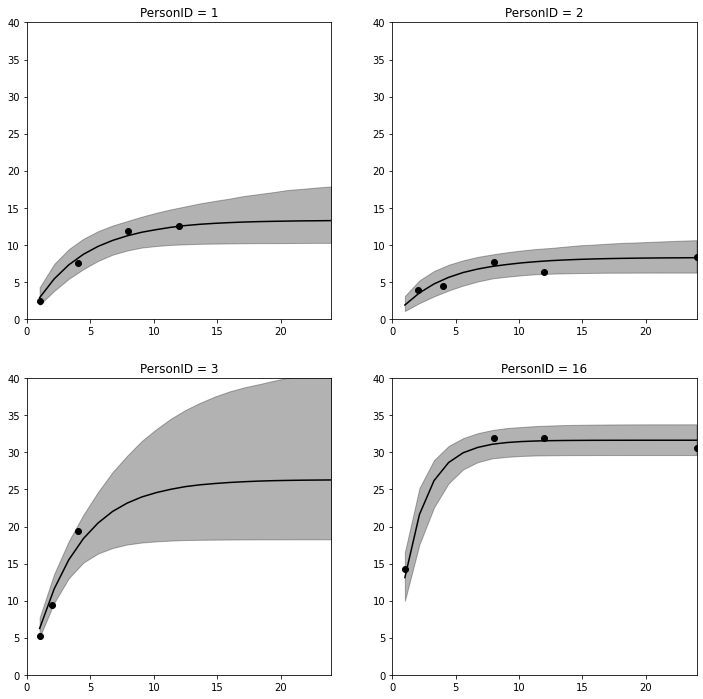

In [12]:
# Fig 9.2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i, ax in zip([1, 2, 3, 16], np.ravel(axes)):
    idx = df["PersonID"]==i
    ax.plot(Time[df[idx]["TimeID"]-1], df[idx]["Y"], 'ko')
    ax.plot(Time_new, y_pred_percentiles[1, i-1], "k")
    ax.fill_between(Time_new, y_pred_percentiles[0, i-1], y_pred_percentiles[2, i-1], color="k", alpha=0.3)
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 40)
    ax.set_title(f"PersonID = {i}")
fig.show()